## Loading

In [1]:
%load_ext autoreload
%autoreload 2

import model as m
import data_processing as dp
import feature_engineering as fe
import make_plots as mp
import parameters as p
import evaluation as e
import os

import pandas as pd
import numpy as np

default_max_rows = pd.get_option('display.max_rows')

In [2]:
# assert len(p.missing_files) == 0
# merged_data_daily, merged_data_monthly = dp.data_loading(p.daily_files, p.monthly_files)
# merged_data_daily, merged_data_monthly = dp.get_market_data(merged_data_daily, merged_data_monthly)
# merged_data_daily = fe.calculate_stock_level_alpha_and_beta(merged_data_daily)
# merged_data_monthly = dp.merge_economic_data(merged_data_monthly)
# dp.save_preprocessed_data(merged_data_monthly, "merged_data_monthly" , index=False); dp.save_preprocessed_data(merged_data_daily, "merged_data_daily", index=False)

# merged_data_daily, merged_data_monthly = dp.data_loading(p.daily_files, p.monthly_files)
# data_daily, data_monthly = fe.feature_construction(merged_data_daily.copy(), merged_data_monthly.copy())
# data_monthly_merged = dp.merge_daily_and_monthly_data(data_daily, data_monthly)

# dp.save_preprocessed_data(data_monthly_merged, "data_monthly_merged")
data_monthly_merged = pd.read_csv(os.path.join(p.cleanedDataPath, "data_monthly_merged.csv"), index_col='date', dtype={p.stockID: str}, parse_dates=True)

In [3]:
data_monthly_imputed = dp.handle_crosssectional_na(data_monthly_merged.copy())
data_monthly_transformed = fe.transform_features(data_monthly_imputed)

Dropped 0 rows with more than 78.38352128462151% missing values.


Increase in missing statistics for each column:
beta_000905: 6.91%
daily_ret_vol_roll_126: 0.03%
return_daily: 0.00%
total_market_value: 5.53%
turnover_daily: 5.53%
000905_close: 0.00%
000905_return_daily: 0.00%
alpha: 6.57%
beta: 6.57%
betasq: 6.57%
maxret: 0.00%
MACD: 0.00%
MACD_Signal: 0.00%
SMA: 0.00%
Upper_Band: 0.03%
Lower_Band: 0.03%
RSI: 3.02%
ROC: 0.31%
volatility_252: 6.72%
volatility_120: 3.29%
volatility_60: 1.65%
SMA_5: 0.00%
SMA_10: 0.00%
SMA_20: 0.00%
SMA_50: 0.00%
SMA_100: 0.00%
SMA_200: 0.00%
illiquidity_monthly: 0.57%
mve_log: 6.22%
return_monthly: 0.54%
ret_vol_monthly: 0.54%
std_dolvol_monthly: 0.57%
std_turnover_monthly: 5.95%
zero_trade_days: 0.81%
000905_return_monthly: 0.54%
CPI: 0.53%
CPI_pct_change: 0.53%
chmom: 10.54%
mom1m_return_monthly: 1.10%
mom6m_return_monthly: 3.85%
mom12m_return_monthly: 6.95%
mom24m_return_monthly: 6.95%
mom36m_return_monthly: 6.95%
mom1m_000905_return_monthly: 1.10%


In [9]:
# grouped = data_monthly_merged.groupby('Ticker')
# for ticker, group in grouped:
#     # Sort the group by 'date'
#     group = group.sort_values(by='date')
#     # Use `shift` to compare with the previous row
#     group['prev_zero_trade_days'] = group['zero_trade_days'].shift(1)
#     # Find rows where the previous 'zero_trade_days' is not NaN, but the current is NaN
#     mask = group['prev_zero_trade_days'].notna() & group['zero_trade_days'].isna()
#     if mask.any():
#         print(f"For ticker {ticker}: There is at least one case where the previous 'zero_trade_days' is not NaN, but the current is NaN.")

## Baseline Model

In [12]:
data_monthly_nona = data_monthly_imputed.dropna().copy()
removed_percentage = (1 - len(data_monthly_nona) / len(data_monthly_imputed)) * 100
print(f"Removed {len(data_monthly_nona)} rows, which is {removed_percentage:.2f}%.")

Removed 416682 rows, which is 19.55%.


In [15]:
price_return_related = ['close', 'close_adj', 'return_daily', '000905_close', 
                        '000905_return_daily', '000905_return_monthly', 'return_monthly',
                        'alpha', 'beta'
                        ]              

data_baseline = data_monthly_nona.drop(price_return_related,axis=1)

In [16]:
X_train, y_train, X_val, y_val, X_test, y_test = m.split_train_val_test(data_baseline.copy(), colsToDrop = ['excess_return'])
input_dim=X_train.shape[1]

print("Training set range:")
print(X_train.index.min(), "to", X_train.index.max())

print("Validation set range:")
print(X_val.index.min(), "to", X_val.index.max())

print("Testing set range:")
print(X_test.index.min(), "to", X_test.index.max())

Training set range:
2015-03-31 00:00:00 to 2021-05-31 00:00:00
Validation set range:
2021-05-31 00:00:00 to 2022-11-30 00:00:00
Testing set range:
2022-11-30 00:00:00 to 2024-03-31 00:00:00


### Hyperparameter tuning

In [6]:
# models_to_tune = [
#     m.OLSModel,
#     m.OLS3Model,
#     m.PLSModel,
#     m.LASSOModel,
#     m.ElasticNetModel,
#     m.GBRTModel,
#     m.RFModel,
#     m.XGBoostModel
# ]
# models_to_tune = [
#     m.XGBoostModel
# ]
# best_trials = e.hyperparameter_tuning(X_train, y_train, X_val, y_val, models_to_tune, n_trials=100)

In [7]:
# e.nn_tunning(range(1, 5+1), X_train, y_train, X_val, y_val)

### Testing

In [8]:
model_classes = [
    m.OLSModel(),
    m.OLS3Model(),
    m.PLSModel(),
    m.LASSOModel(),
    m.ElasticNetModel(),
    m.GBRTModel(), #extremely slow 
    m.RFModel(), 
    m.XGBoostModel()
]
num_layers_range = range(1, 5+1)
for num_layers in num_layers_range:
    model_classes.append(m.NNModel(input_dim=input_dim, num_layers=num_layers))
models_fitted, model_res, model_r_2 = m.fit_model(X_train, X_test,  X_val, y_val, y_train, y_test, model_classes)

OLSModel
OLS3Model
PLSModel
LASSOModel
ElasticNetModel
GBRTModel
RFModel
XGBoostModel
NNModel_nn1


Training:  10%|█         | 10/100 [01:23<12:28,  8.32s/it, Training loss=0.0218, Validation loss=0.02] 


Early stopping triggered at epoch 11
NNModel_nn2


Training:   7%|▋         | 7/100 [01:05<14:24,  9.29s/it, Training loss=0.0218, Validation loss=0.0203]


Early stopping triggered at epoch 8
NNModel_nn3


Training:   8%|▊         | 8/100 [01:21<15:32, 10.14s/it, Training loss=0.0218, Validation loss=0.0201]


Early stopping triggered at epoch 9
NNModel_nn4


Training:  10%|█         | 10/100 [01:58<17:45, 11.84s/it, Training loss=0.0218, Validation loss=0.02] 


Early stopping triggered at epoch 11
NNModel_nn5


Training:   5%|▌         | 5/100 [01:06<20:56, 13.23s/it, Training loss=0.0218, Validation loss=0.0201]

Early stopping triggered at epoch 6
OLSModel: -3.952722727443433
OLS3Model: -3.944255798884204
PLSModel: -3.9588289846051
LASSOModel: -3.957814939871847
ElasticNetModel: -3.957851629009099
GBRTModel: -3.978476442409592
RFModel: -4.262471221044477
XGBoostModel: -3.963006762336992
NNModel_nn1: -4.020113327689079
NNModel_nn2: -3.946702108982601
NNModel_nn3: -3.9590972154298
NNModel_nn4: -3.9614414022136
NNModel_nn5: -3.9706976659848072


### Feature Importance

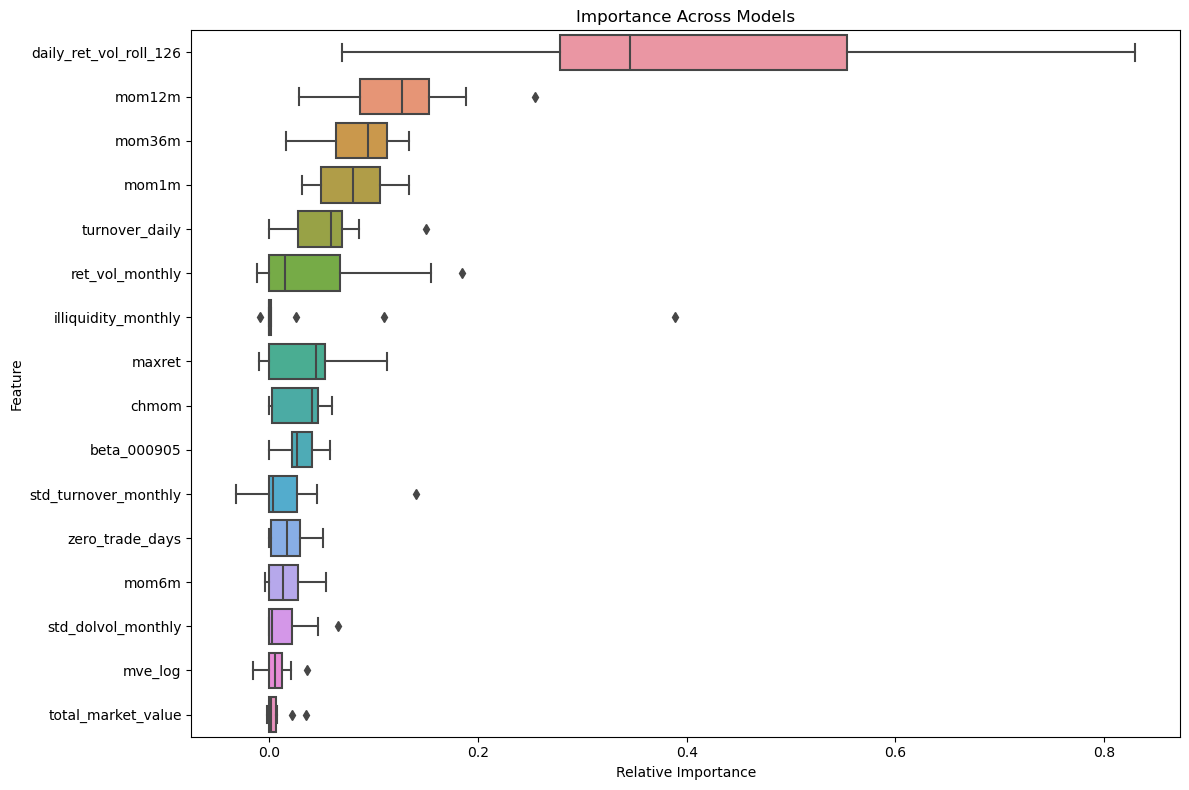

In [37]:
X_train, y_train, X_val, y_val, X_test, y_test = m.split_train_val_test(data_baseline.copy(), colsToDrop = ['excess_return'])
importance_df_baseline = e.calculate_feature_importance(model_classes, X_train, y_train, X_val, y_val, features=X_train.columns, permutation_importance=True)
mp.feature_importance_boxplot(importance_df_baseline)
# sorted_df = mp.characteristic_feature_importance(importance_df_baseline)

## Current Model

In [4]:
data_monthly_nona = data_monthly_transformed.dropna().copy()
removed_percentage = (1 - len(data_monthly_nona) / len(data_monthly_transformed)) * 100
print(f"Removed {len(data_monthly_nona)} rows, which is {removed_percentage:.2f}%.")

cols_to_drop = ['close', 'return_daily', '000905_return_daily', 'return_monthly',
                'alpha', 'beta_000905'
                ]             
data_model = data_monthly_nona.copy()

Removed 478422 rows, which is 8.04%.


In [5]:
X_train, y_train, X_val, y_val, X_test, y_test = m.split_train_val_test(data_model.copy(), colsToDrop = cols_to_drop)
input_dim=X_train.shape[1]

print("Training set range:")
print(X_train.index.min(), "to", X_train.index.max())

print("Validation set range:")
print(X_val.index.min(), "to", X_val.index.max())

print("Testing set range:")
print(X_test.index.min(), "to", X_test.index.max())

Training set range:
2013-02-28 00:00:00 to 2017-12-31 00:00:00
Validation set range:
2018-01-31 00:00:00 to 2019-12-31 00:00:00
Testing set range:
2020-01-31 00:00:00 to 2021-12-31 00:00:00


## Tuning

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, HuberRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor 

scaler = StandardScaler()
X_train_scaled, X_val_scaled = scaler.fit_transform(X_train), scaler.transform(X_val)

#### LinearRegression

In [25]:
model = LinearRegression(n_jobs=-1).fit(X_train_scaled, y_train)
predictions = model.predict(X_val_scaled)
r_2_train = e.calculate_r2_oos(y_val.values, model.predict(X_val_scaled))
r_2_val = e.calculate_r2_oos(y_val.values, predictions)
print(f"r_2_train: {r_2_train}, r_2_val: {r_2_val}", )

r_2_train: -0.9043189165196943, r_2_val: -0.9043189165196943


#### Huberloss

In [26]:
model = HuberRegressor(max_iter=5000).fit(X_train_scaled, y_train)
predictions = model.predict(X_val_scaled)
r_2_train = e.calculate_r2_oos(y_val.values, model.predict(X_val_scaled))
r_2_val = e.calculate_r2_oos(y_val.values, predictions)
print(f"r_2_train: {r_2_train}, r_2_val: {r_2_val}", )

r_2_train: -0.19551155868612646, r_2_val: -0.19551155868612646


In [79]:
param_grid_huber = {
    'epsilon': [1, 1.35, 1.7, 3, 6, 10],
    'alpha': [0, 0.01, 0.1, 0.5, 1],
    'max_iter': [5000]
    }

results_huber = e.explore_parameter_grid(HuberRegressor, param_grid_huber, X_train_scaled, y_train, X_val_scaled, y_val)

Exploring Parameters: 100%|██████████| 30/30 [03:30<00:00,  7.01s/it]


c:\Users\Howard\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


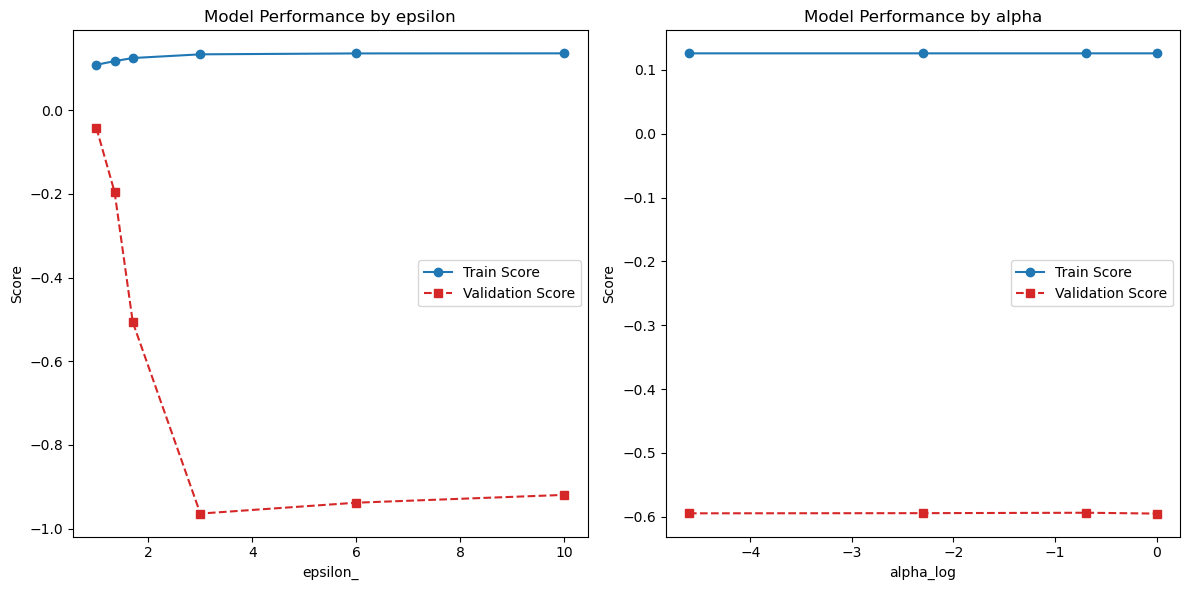

In [82]:
mp.plot_model_performance(results_huber.copy(), param_grid_huber.keys())

#### PLS

In [28]:
model = PLSRegression(max_iter=5000).fit(X_train_scaled, y_train)
predictions = model.predict(X_val_scaled)
r_2_train = e.calculate_r2_oos(y_val.values, model.predict(X_val_scaled))
r_2_val = e.calculate_r2_oos(y_val.values, predictions)
print(f"r_2_train: {r_2_train}, r_2_val: {r_2_val}", )

r_2_train: 0.002011950337456714, r_2_val: 0.002011950337456714


In [85]:
n_feature = X_train_scaled.shape[1]
n_components = []
while n_feature != 1:
    n_components.append(n_feature)
    n_feature //= 1.5 
    n_feature = int(n_feature)

param_grid_pls = {
    'n_components': n_components,
    'max_iter': [5000]
    }

results_pls = e.explore_parameter_grid(PLSRegression, param_grid_pls, X_train_scaled, y_train, X_val_scaled, y_val)

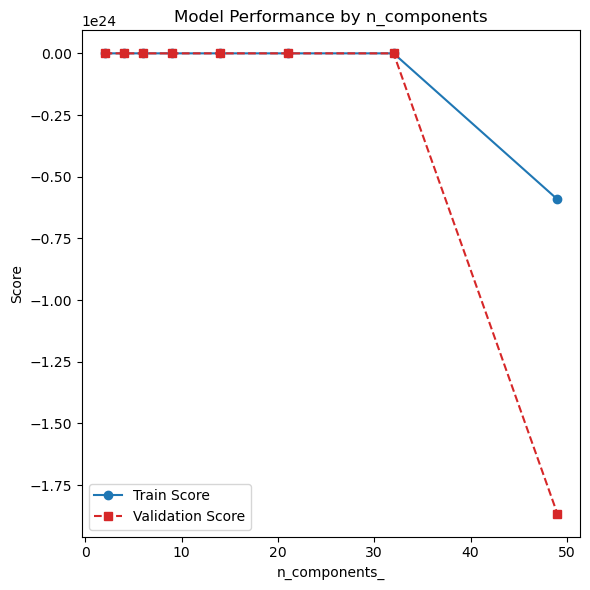

In [86]:
mp.plot_model_performance(results_pls.copy(), param_grid_pls.keys())

### Lasso

In [8]:
model = Lasso(max_iter=5000).fit(X_train_scaled, y_train)
predictions = model.predict(X_val_scaled)
r_2_train = e.calculate_r2_oos(y_val.values, model.predict(X_val_scaled))
r_2_val = e.calculate_r2_oos(y_val.values, predictions)
print(f"r_2_train: {r_2_train}, r_2_val: {r_2_val}", )

r_2_train: -0.02392923386479051, r_2_val: -0.02392923386479051


In [17]:
param_grid_lasso = {
    'alpha': [0.0001, 0.001, 0.1, 1, 5, 10],
    'max_iter': [5000]
    }

results_lasso = e.explore_parameter_grid(Lasso, param_grid_lasso, X_train_scaled, y_train, X_val_scaled, y_val)

Exploring Parameters: 100%|██████████| 6/6 [00:22<00:00,  3.83s/it]


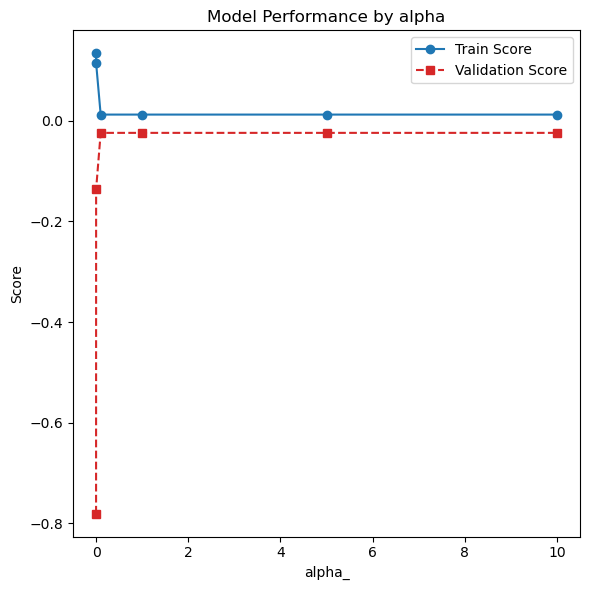

In [18]:
mp.plot_model_performance(results_lasso, param_grid_lasso.keys())

#### ElasticNet

In [9]:
model = ElasticNet(max_iter=5000).fit(X_train_scaled, y_train)
predictions = model.predict(X_val_scaled)
r_2_train = e.calculate_r2_oos(y_val.values, model.predict(X_val_scaled))
r_2_val = e.calculate_r2_oos(y_val.values, predictions)
print(f"r_2_train: {r_2_train}, r_2_val: {r_2_val}", )

r_2_train: -0.02392923386479051, r_2_val: -0.02392923386479051


In [21]:
param_grid_en = {
    'alpha': [0.0001, 0.001, 0.1, 1, 5, 10],
    'l1_ratio': [0.0001, 0.01, 0.1, 0.5, 1],
    'max_iter': [5000]
    }

results_en = e.explore_parameter_grid(ElasticNet, param_grid_en, X_train_scaled, y_train, X_val_scaled, y_val)

Exploring Parameters:   0%|          | 0/30 [00:00<?, ?it/s]

: 

In [ ]:
mp.plot_model_performance(results_en, param_grid_en.keys())

### Hyperparameter tuning

In [8]:
models_to_tune = [
    # m.OLSModel,
    # m.OLS3Model,
    # m.PLSModel,
    # m.LASSOModel,
    # m.ElasticNetModel,
    # m.GBRTModel,
    # m.RFModel,
    # m.XGBoostModel
]
best_trials = e.hyperparameter_tuning(X_train, y_train, X_val, y_val, models_to_tune, n_trials=100)

Tuning Models:   0%|          | 0/5 [00:00<?, ?it/s]


TypeError: 'NNModel' object is not callable

### Testing

In [6]:
model_classes = [
    m.OLSModel(),
    # m.OLS3Model(),
    # m.PLSModel(),
    m.LASSOModel(),
    m.ElasticNetModel(),
    # m.GBRTModel(), #extremely slow 
    # m.RFModel(), 
    m.XGBoostModel()
]
num_layers_range = range(1, 5+1)
# for num_layers in num_layers_range:
#     model_classes.append(m.NNModel(input_dim=input_dim, num_layers=num_layers))
models_fitted, model_res, model_r_2 = m.fit_model(X_train, X_test,  X_val, y_val, y_train, y_test, model_classes)

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

OLSModel


Testing:  20%|██        | 1/5 [00:33<02:12, 33.01s/it, Model Name=OLSModel, R_2=-1.36]


OLS3Model


KeyError: "['mom1m'] not in index"

### Feature Importance

In [16]:
model_classes = [
    m.OLSModel(),
    m.OLS3Model(),
    m.PLSModel(),
    m.LASSOModel(),
    m.ElasticNetModel(),
    m.GBRTModel(), #extremely slow 
    m.RFModel(), 
    m.XGBoostModel()
]
num_layers_range = range(1, 1+1)
for num_layers in num_layers_range:
    model_classes.append(m.NNModel(input_dim=input_dim, num_layers=num_layers))

importance_df_current = e.calculate_feature_importance(model_classes, X_train, y_train, X_val, y_val, features=X_train.columns, permutation_importance=True)

Calculating Feature Importance:   0%|          | 0/8 [00:00<?, ?it/s, Model Name=OLSModel]

: 

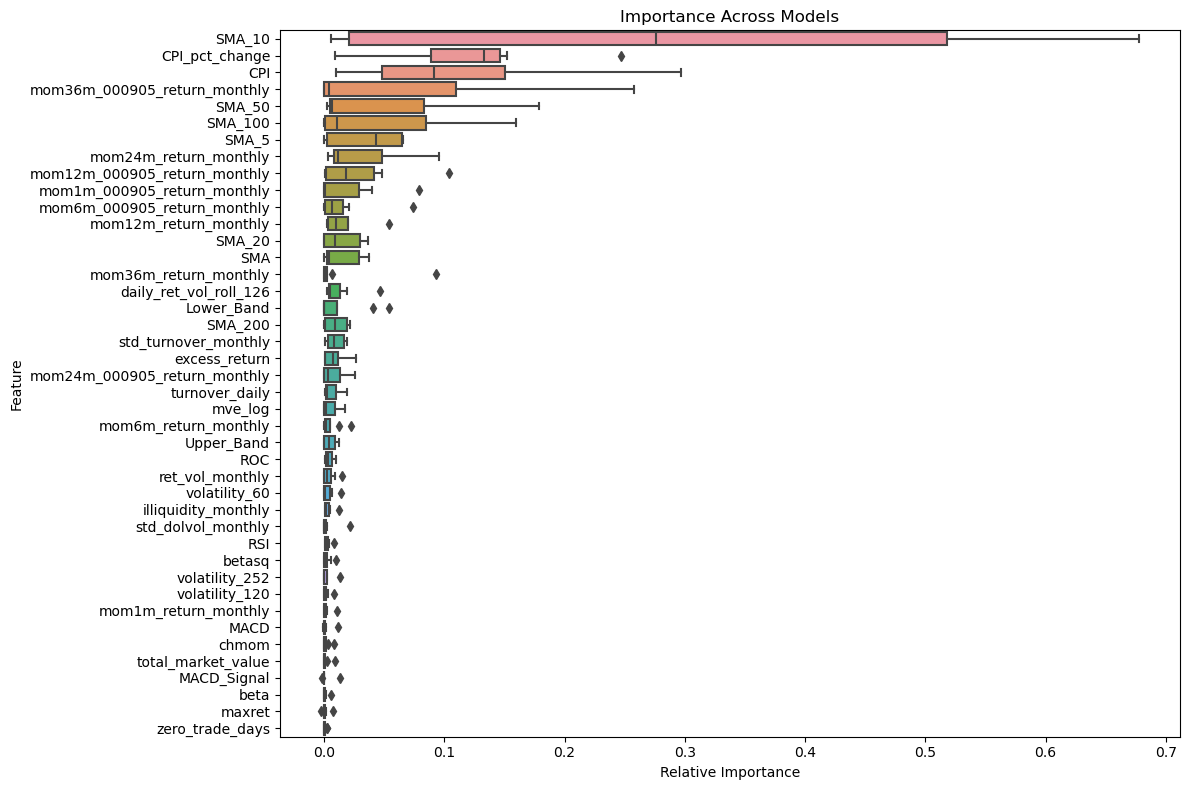

In [45]:
mp.feature_importance_boxplot(importance_df_current)


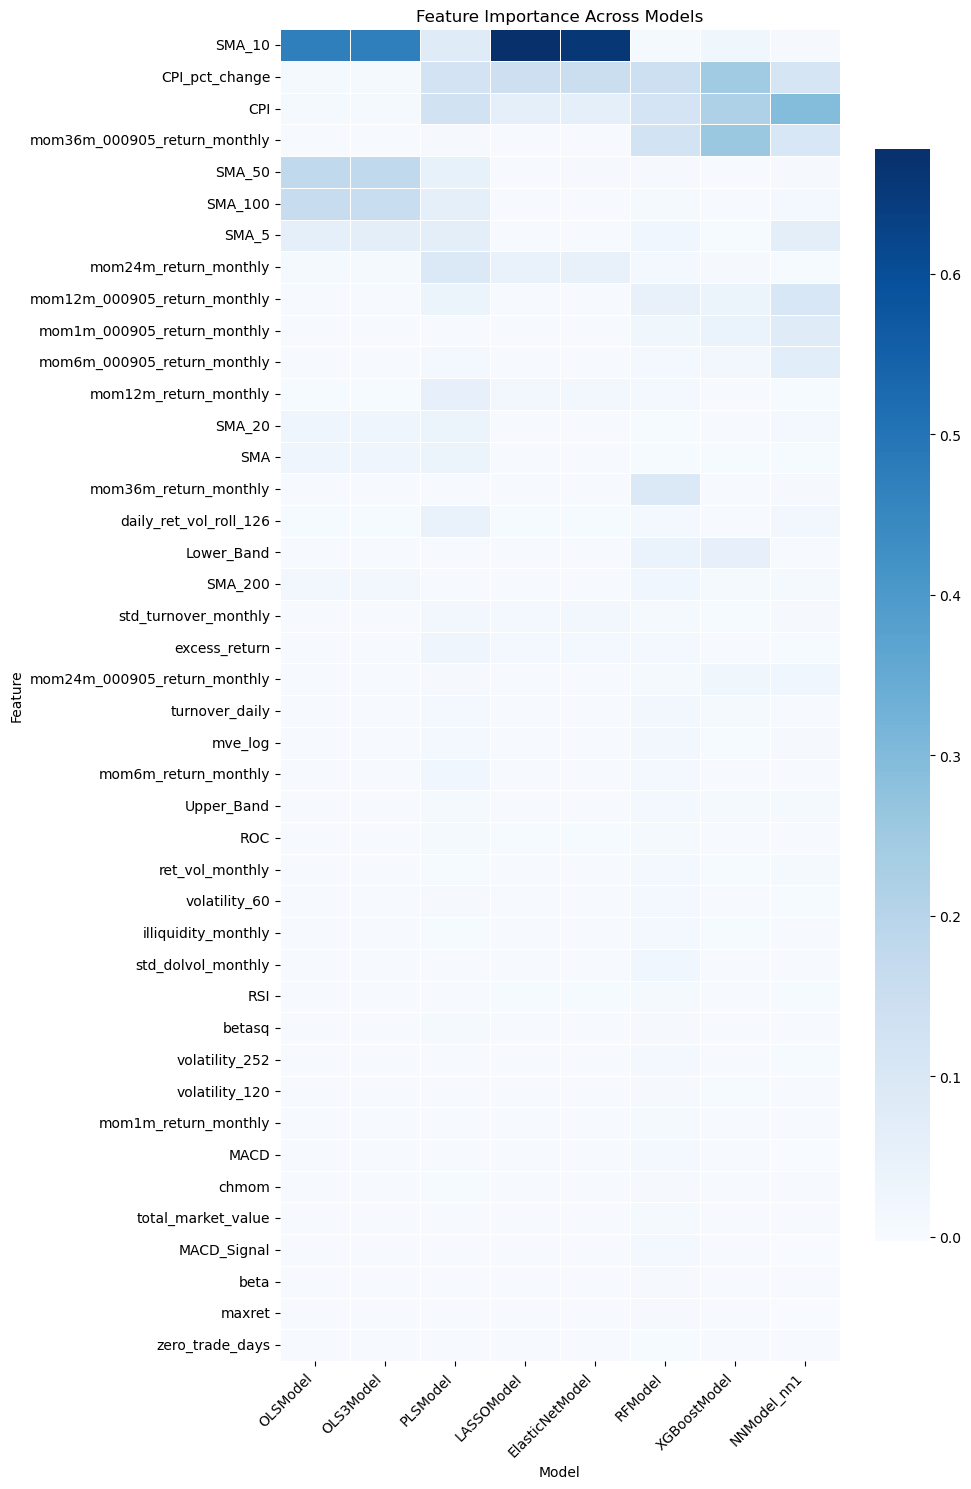

In [46]:
sorted_df = mp.characteristic_feature_importance(importance_df_current)

## Portfolio analysis